In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats

In [6]:
import warnings
warnings.filterwarnings("ignore")

## prep

In [7]:
df = pd.read_csv('data_final.csv')

In [8]:
df = df.dropna(subset=['bpm', 'energy', 'danceability', 'loudness',
                        'valence', 'length', 'acousticness', 'artist_seperation'])

In [9]:
def mode_language(series):
    non_null = series.dropna()
    if non_null.empty:
        return None
    else:
        return non_null.mode().iloc[0]

artist_mode = df.groupby('artist')['language'].apply(mode_language)

def impute_language(row):
    if pd.isnull(row['language']):
        return artist_mode.get(row['artist'], None)
    else:
        return row['language']

df['language'] = df.apply(impute_language, axis=1)

In [10]:
missing_rows = df[df.isnull().any(axis=1)]
print(f'The percentage of entries with missing data: {len(missing_rows)/len(df) * 100:.2f}%')
print("- " * 30)
for column in df.columns:
    missing_count = df[column].isnull().sum()
    missing_percentage = (missing_count / len(df)) * 100
    print(f"  Column '{column}': \n       Missing values count: {missing_count}, {missing_percentage:.2f}% missing\n")

The percentage of entries with missing data: 39.23%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
  Column 'Unnamed: 0': 
       Missing values count: 0, 0.00% missing

  Column 'track_id': 
       Missing values count: 0, 0.00% missing

  Column 'artist': 
       Missing values count: 0, 0.00% missing

  Column 'song': 
       Missing values count: 0, 0.00% missing

  Column 'release_date': 
       Missing values count: 20, 0.59% missing

  Column 'total_weeks': 
       Missing values count: 0, 0.00% missing

  Column 'peak_position': 
       Missing values count: 0, 0.00% missing

  Column 'peak_streams': 
       Missing values count: 0, 0.00% missing

  Column 'total_streams': 
       Missing values count: 0, 0.00% missing

  Column 'release_month': 
       Missing values count: 20, 0.59% missing

  Column 'release_season': 
       Missing values count: 20, 0.59% missing

  Column 'first_peak_date': 
       Missing values count: 0, 0.00% missing

  Column 'peak_season

In [11]:
df = df.dropna(subset=['language'])

In [12]:
df['english_lang'] = (df['language'] == 'English').astype(int)
df['ukrainian_lang'] = (df['language'] == 'Ukrainian').astype(int)
df['russian_lang'] = (df['language'] == 'Russian').astype(int)
df['other_lang'] = (
    (df['language'] != 'Russian') &
    (df['language'] != 'Ukrainian') &
    (df['language'] != 'English')
).astype(int)

In [13]:
df['fall_release'] = (df['release_season'] == 'Fall').astype(int)
df['spring_release'] = (df['release_season'] == 'Spring').astype(int)
df['summer_release'] = (df['release_season'] == 'Summer').astype(int)
df['winter_release'] = (df['release_season'] == 'Winter').astype(int)

In [14]:
df['top50'] = (df['peak_position'] < 51).astype(int)

In [15]:
df['top10'] = (df['peak_position'] < 11).astype(int)

In [16]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['after2022'] = (df['release_date'] > pd.to_datetime('2022-02-24')).astype(int)

In [17]:
df.head()

,Unnamed: 0,track_id,artist,song,release_date,total_weeks,peak_position,peak_streams,total_streams,release_month,...,ukrainian_lang,russian_lang,other_lang,fall_release,spring_release,summer_release,winter_release,top50,top10,after2022
0,0,61BaxM1NIcadLu3gtWm2uT,sadsvit,силуети,2022-10-28,126,1,263673,17102909,10.0,...,1,0,0,1,0,0,0,1,1,1
1,1,2QjOHCTQ1Jl3zawyYOpxh6,the neighbourhood,sweater weather,2013-04-22,234,16,75675,12393368,4.0,...,0,0,0,0,1,0,0,1,0,0
2,2,4MQmxIxM5CXKjdq4IrCWhd,sadsvit,касета,2021-12-13,154,1,296336,11790369,12.0,...,1,0,0,0,0,0,1,1,1,0
3,3,6gtK39SLszESqJFu2SkId3,wellboy,додому,2022-12-16,117,5,115203,10613534,12.0,...,1,0,0,0,0,0,1,1,1,1
4,4,66Xj2OpnDALdW0G509b9yY,yaktak,погляд,2022-10-13,108,1,171097,9534146,10.0,...,1,0,0,1,0,0,0,1,1,1


In [18]:
language_dummy_columns = ['english_lang', 'ukrainian_lang', 'other_lang']

time_indicator_column = 'after2022'

for lang_col in language_dummy_columns:
    interaction_col_name = f"{lang_col}_x_{time_indicator_column}"
    df[interaction_col_name] = df[lang_col] * df[time_indicator_column]

In [19]:
logistic_model = smf.logit(
    'top50 ~ energy + danceability + length + acousticness + artist_seperation +'
    'english_lang + other_lang + spring_release + summer_release + winter_release + '
    'english_lang_x_after2022 + other_lang_x_after2022',
    data=df
)

logistic_results = logistic_model.fit()

print(logistic_results.summary())

Optimization terminated successfully.
         Current function value: 0.628405
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  top50   No. Observations:                 3282
Model:                          Logit   Df Residuals:                     3269
Method:                           MLE   Df Model:                           12
Date:                Wed, 07 May 2025   Pseudo R-squ.:                 0.05194
Time:                        12:33:44   Log-Likelihood:                -2062.4
converged:                       True   LL-Null:                       -2175.4
Covariance Type:            nonrobust   LLR p-value:                 1.356e-41
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.0782      0.386     -5.377      0.000      -2.836

## Binary outcome

In [20]:
print(df['top50'].value_counts())

top50
0    2043
1    1239
Name: count, dtype: int64


## Linearity in log odds

Optimization terminated successfully.
         Current function value: 0.628405
         Iterations 5


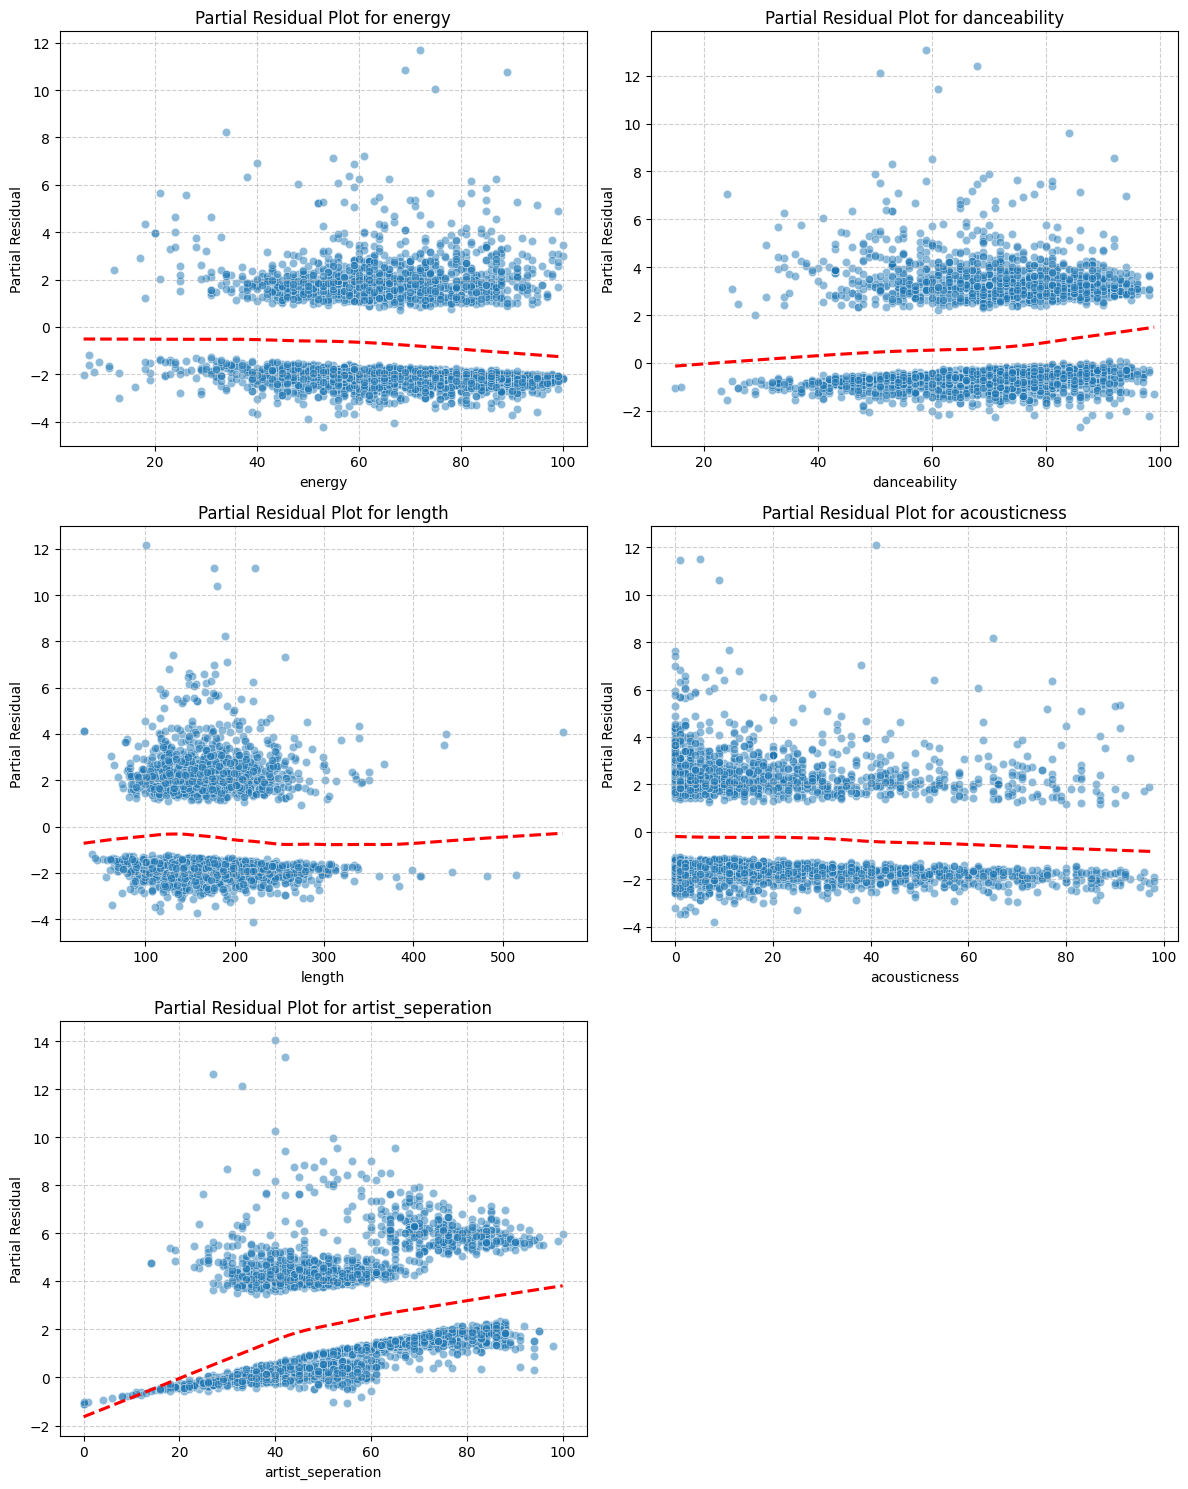

In [21]:
continuous_predictors = ['energy', 'danceability', 'length', 'acousticness', 'artist_seperation']
original_formula = ('top50 ~ energy + danceability + length + acousticness + artist_seperation +'
                    'english_lang + other_lang + spring_release + summer_release + winter_release + '
                    'english_lang_x_after2022 + other_lang_x_after2022')

original_logistic_model = smf.logit(original_formula, data=df)
original_logistic_results = original_logistic_model.fit()

n_predictors = len(continuous_predictors)
n_cols = 2
n_rows = (n_predictors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

exog = original_logistic_results.model.exog
exog_names = original_logistic_results.model.exog_names

for i, predictor in enumerate(continuous_predictors):
    predictor_index = exog_names.index(predictor)
    if hasattr(original_logistic_results, 'resid_working'):
        working_residuals = original_logistic_results.resid_working
    else:
        lin_pred = original_logistic_results.predict(linear=True)
        prob = original_logistic_results.predict(linear=False)
        working_residuals = (original_logistic_results.model.endog - prob) / (prob * (1 - prob))

    beta = original_logistic_results.params[predictor]
    X_predictor = exog[:, predictor_index]
    partial_resids = working_residuals + beta * X_predictor
    sns.scatterplot(x=X_predictor, y=partial_resids, ax=axes[i], alpha=0.5)
    sns.regplot(x=X_predictor, y=partial_resids, lowess=True, scatter=False,
                line_kws={'color': 'red', 'linestyle': '--'}, ax=axes[i])

    axes[i].set_xlabel(predictor)
    axes[i].set_ylabel('Partial Residual')
    axes[i].set_title(f'Partial Residual Plot for {predictor}')
    axes[i].grid(True, linestyle='--', alpha=0.6)

for j in range(n_predictors, len(axes)):
      fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The points a little scattred, but a red line is near to zore it means there is a linear dependence between energy and logarifmic probabulity to be in top 50; as we can other plots (denceability, length, acousticness) also have a linear relationship based on the spread and the red line, which is quite straight.

But in arist_separation red line is a upward curve that mean the arist_separation and top 50 haven't a linearly dependence

In [22]:
formula_with_quadratic = (
    'top50 ~ energy + danceability + length + acousticness + '
    'artist_seperation + I(artist_seperation**2) + '
    'english_lang + other_lang + spring_release + summer_release + winter_release + '
    'english_lang_x_after2022 + other_lang_x_after2022'
)

logistic_model_quad = smf.logit(formula_with_quadratic, data=df)
logistic_results_quad = logistic_model_quad.fit()
print(logistic_results_quad.summary())

aic_value = logistic_results_quad.aic
bic_value = logistic_results_quad.bic

print(f"\nAIC: {aic_value}")
print(f"BIC: {bic_value}")

Optimization terminated successfully.
         Current function value: 0.624531
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  top50   No. Observations:                 3282
Model:                          Logit   Df Residuals:                     3268
Method:                           MLE   Df Model:                           13
Date:                Wed, 07 May 2025   Pseudo R-squ.:                 0.05779
Time:                        12:33:46   Log-Likelihood:                -2049.7
converged:                       True   LL-Null:                       -2175.4
Covariance Type:            nonrobust   LLR p-value:                 3.244e-46
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -3.8086      0.530     -7.184      0.000      -4.

## Mullticolinearity

In [23]:
predictors_for_vif = df[['energy', 'danceability', 'length', 'acousticness',
                        'artist_seperation', 'spring_release', 'summer_release', 'winter_release', 'other_lang_x_after2022',
                        'english_lang', 'other_lang',
                        'english_lang_x_after2022']]

X_vif = add_constant(predictors_for_vif, prepend=False)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data[vif_data["feature"] != 'const'])

                     feature       VIF
0                     energy  1.335882
1               danceability  1.120372
2                     length  1.131592
3               acousticness  1.324844
4          artist_seperation  2.365345
5             spring_release  1.393321
6             summer_release  1.386166
7             winter_release  1.366065
8     other_lang_x_after2022  2.238435
9               english_lang  2.781965
10                other_lang  2.373310
11  english_lang_x_after2022  1.528395


mullticolinearity is small to moderate

## Outliers

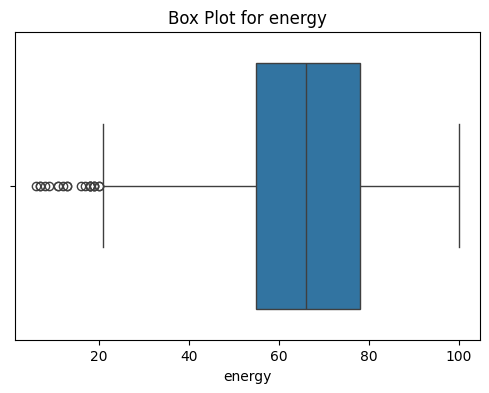

In [24]:
feature = 'energy'

plt.figure(figsize=(6, 4))
sns.boxplot(x=df[feature])
plt.title(f'Box Plot for {feature}')
plt.show()

In [25]:
formula = (
    'top50 ~ energy + danceability + acousticness + '
    'artist_seperation + '
    'english_lang + other_lang + '
    'english_lang_x_after2022'
)

artist_col = 'artist'
outlier_col = 'artist_seperation'

Q1 = df[outlier_col].quantile(0.25)
Q3 = df[outlier_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"   IQR Bounds for {outlier_col}: Lower={lower_bound:.4f}, Upper={upper_bound:.4f}")

is_outlier = (df[outlier_col] < lower_bound) | (df[outlier_col] > upper_bound)
num_outliers = is_outlier.sum()

model_full = smf.logit(formula, data=df)
indices_full = model_full.data.row_labels
groups_full = df.loc[indices_full, artist_col]

results_full = model_full.fit(cov_type='cluster',
                                cov_kwds={'groups': groups_full},
                                method='bfgs', maxiter=100)

print("   Fit successful (Full Data).")

if num_outliers > 0:
    df_no_outliers = df[~is_outlier].copy()
else:
    df_no_outliers = df.copy()


model_reduced = smf.logit(formula, data=df_no_outliers)
indices_reduced = model_reduced.data.row_labels
groups_reduced = df_no_outliers.loc[indices_reduced, artist_col]

results_reduced = model_reduced.fit(cov_type='cluster',
                                            cov_kwds={'groups': groups_reduced},
                                            method='bfgs', maxiter=100)

print("Comparing Results:")

if 'results_reduced' in locals():
    comparison = pd.DataFrame({
        'Coef_Full': results_full.params,
        'P_Full': results_full.pvalues,
        'Coef_Reduced': results_reduced.params,
        'P_Reduced': results_reduced.pvalues
    })
    comparison['Diff_Coef'] = comparison['Coef_Reduced'] - comparison['Coef_Full']
    comparison['Sig_Change'] = np.where(
        (comparison['P_Full'] <= 0.05) != (comparison['P_Reduced'] <= 0.05),
        "YES", "No"
    )

    print(comparison)
else:
    print("   Cannot compare results (reduced model not fitted).")

   IQR Bounds for artist_seperation: Lower=-0.5000, Upper=107.5000
Optimization terminated successfully.
         Current function value: 0.630440
         Iterations: 42
         Function evaluations: 47
         Gradient evaluations: 47
   Fit successful (Full Data).
Optimization terminated successfully.
         Current function value: 0.630440
         Iterations: 42
         Function evaluations: 47
         Gradient evaluations: 47
Comparing Results:
                          Coef_Full        P_Full  Coef_Reduced     P_Reduced  \
Intercept                 -2.479384  2.683462e-09     -2.479384  2.683462e-09   
energy                    -0.009003  8.707022e-03     -0.009003  8.707022e-03   
danceability               0.013429  9.369154e-04      0.013429  9.369154e-04   
acousticness              -0.005326  2.570574e-02     -0.005326  2.570574e-02   
artist_seperation          0.042046  1.919494e-17      0.042046  1.919494e-17   
english_lang              -1.612736  2.752806e-21    